# Diffusion Models

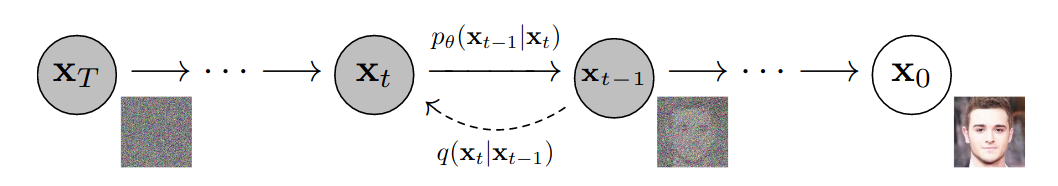

In this image, the distribution $q_{theta}$ represents the forward diffusion process. Below, I simulate the forward diffusion process on a simple distribution. Later, we'll reverse the diffusion process to obtain a generative model of data. 

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



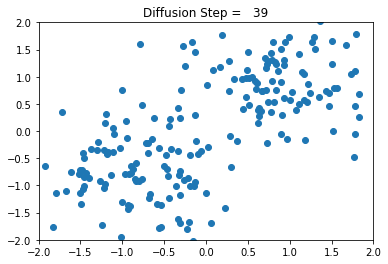

In [1]:
import svgpathtools as svg
from vectorrvnn.geometry import *
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.distributions import *
from torch import optim
import math
from sympy import * 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML
    
%matplotlib inline

init_printing()

data1 = np.array([1., 1.]) + 0.1 * np.random.randn(100, 2)
data2 = np.array([-1., -1.]) + 0.1 * np.random.randn(100, 2)
data = np.concatenate([data1, data2])

pts = data
# a = svg.Document('s.svg')
# lines = [flattenPath(p.path) for p in a.paths()]
# pts = [np.array(equiDistantPointsOnPolyline(a, l, nSamples=200, normalize=True)).T for l in lines]
# pts = np.vstack(pts)
# data = pts

BETA    = 1e-2 # Diffusion rate
STEPS   = 40 # Diffusion steps

def forward_step (pts) : 
    mu_new = pts * np.sqrt(1 - BETA)
    pts_ = mu_new + np.sqrt(BETA) * np.random.randn(*mu_new.shape)
    return pts_

fig, ax = plt.subplots()

ax.set_xlim((-2, 2))            
ax.set_ylim((-2, 2))
txt_title = ax.set_title('')
scat = ax.scatter([], [])

def drawframe (t):
    global pts
    scat.set_offsets(pts)
    txt_title.set_text('Diffusion Step = {0:4d}'.format(t))
    pts = forward_step(pts)
    return (scat,)

anim = animation.FuncAnimation(fig, drawframe, frames=STEPS, interval=200, blit=True)
HTML(anim.to_html5_video())

## Fixed Point of Forward Diffusion

The forward diffusion process consists of perturbing points by sampling their new location from a gaussian distribution. Here, $\beta$ is the diffusion rate, determining how far points can go in one time-step. 

$$
X^{(i)} | X^{(i - 1)} \sim \mathcal{N} (\sqrt{1 - \beta} X^{(i - 1)}, \beta I)
$$

The animation shows that after certain time-steps, the points are distributed as per isotropic gaussian. Why does this happen? Why is the isotropic gaussian the fixed point of the forward diffusion kernel. 

A simple way to see what is happening is to look at one point in the data-set and see what it's probability distribution looks like after two steps of diffusion.

$$ x_0 \rightarrow x_1 \rightarrow x_2 $$

Then $Pr(X^{(2)} = x_2 | X^{(0)} = x_0)$ is given by:

In [2]:
def gaussian (x, mu, sigma) : 
    """ 
    Expression for probability at x according to 
    gaussian distribution.
    """
    return 1 / (sigma * sqrt(2 * pi)) * exp(-((x - mu) / sigma) ** 2 / 2)

var('x_0 x_1 x_2 pi beta Z')

I = gaussian(x_1, x_0 * sqrt(1 - beta), sqrt(beta)) * gaussian(x_2, x_1 * sqrt(1 - beta), sqrt(beta))
I = simplify(I)
pprint(Integral(I, (x_1, -oo, oo)))

∞                                                        
⌠                                                        
⎮    ⎛                   2                      2⎞       
⎮    ⎜⎛     _______     ⎞    ⎛     _______     ⎞ ⎟       
⎮   -⎝⎝x₀⋅╲╱ 1 - β  - x₁⎠  + ⎝x₁⋅╲╱ 1 - β  - x₂⎠ ⎠       
⎮   ───────────────────────────────────────────────      
⎮                         2⋅β                            
⎮  ℯ                                                     
⎮  ──────────────────────────────────────────────── d(x₁)
⎮                       2⋅β⋅π                            
⌡                                                        
-∞                                                       


We'll solve this integral with these steps.

* Complete the square in the exponent in terms of $x_1$
* Notice that the integrand is a gaussian in $x_1$
* Divide and multiply it by normalization constant
* Everything left after integrating over $x_1$ is the distribution of the second diffusion step

In [3]:
# Perform step 1
def completeSquare (quadratic, x) : 
    """ 
    Write the quadratic as (A * x - B) ** 2 - C
    and obtain expressions for coefficients A, B and C
    """ 
    A = sqrt(simplify(diff(quadratic, x, x) / 2))
    exp = simplify(diff(quadratic, x).subs(x, 0))
    B = simplify(exp / (-2 * A)) 
    C = simplify(B ** 2 - quadratic.subs(x, 0))
    return { 'A': A, 'B': B, 'C': C }

C_1 = Wild("C_1")
C_2 = Wild("C_2")
E = Wild("E")

print("Integral is of the form:\n")
pprint(Integral(C_1 * exp(-C_2 * E), (x_1, -oo, oo)))

print("Where E is:\n")
match = I.match(C_1 * exp(-C_2 * E))
E = match[E].expand()
pprint(E)

print("After completing the square\n")

perfectSq = completeSquare(E, x_1)
A, B, C = Wild("A"), Wild("B"), Wild("C")
pprint(Integral(C_1 * exp(-C_2 * ((A * x_1 ** 2 - B) ** 2 - C)), (x_1, -oo, oo)))

Integral is of the form:

∞                 
⌠                 
⎮      -C₂⋅E      
⎮  C₁⋅ℯ      d(x₁)
⌡                 
-∞                
Where E is:

      2       2     2             _______       2             _______     2
- β⋅x₀  - β⋅x₁  + x₀  - 2⋅x₀⋅x₁⋅╲╱ 1 - β  + 2⋅x₁  - 2⋅x₁⋅x₂⋅╲╱ 1 - β  + x₂ 
After completing the square

∞                                   
⌠                                   
⎮          ⎛                2⎞      
⎮          ⎜     ⎛  2      ⎞ ⎟      
⎮      -C₂⋅⎝-C + ⎝x₁ ⋅A - B⎠ ⎠      
⎮  C₁⋅ℯ                        d(x₁)
⌡                                   
-∞                                  


In [4]:
# Perform step 4: bring out everything independent of x_1
print("Terms independent of x_1 are seperated:\n") 
pprint(C_1 * exp(C_2 * C) * Integral(exp (-C_2 * (A ** 2) * (x_1 - B / A) ** 2), (x_1, -oo, oo)))

print("The integral evaluates to some constant Z:\n")
pprint(C_1 * exp(C_2 * C) * Z)

print("To find the resulting gaussian parameters, just need to look at C_2 * C:\n")
C = perfectSq['C']
psq = completeSquare(C, x_2)
C = simplify((psq['A'] * x_2 - psq['B']) ** 2 - psq['C'])
pprint(match[C_2] * C)

Terms independent of x_1 are seperated:

         ∞                         
         ⌠                         
         ⎮                  2      
         ⎮     2    ⎛     B⎞       
         ⎮   -A ⋅C₂⋅⎜x₁ - ─⎟       
    C⋅C₂ ⎮          ⎝     A⎠       
C₁⋅ℯ    ⋅⎮  ℯ                 d(x₁)
         ⌡                         
         -∞                        
The integral evaluates to some constant Z:

      C⋅C₂
Z⋅C₁⋅ℯ    
To find the resulting gaussian parameters, just need to look at C_2 * C:

                 2
(x₀⋅(β - 1) + x₂) 
──────────────────
   2⋅β⋅(β - 2)    


Matching this expression with:

$$-\frac{(x_2 - \mu)^2}{2 \sigma^2}$$

We get: 

$$ 
\mu = (\sqrt{1 - \beta})^2 x_0
$$

$$
\sigma^2 = 1 - (1 - \beta)^2
$$

Applying this result iteratively, we get: 

$$
Pr(X^{(t)} = x_t | X^{(0)} = x_0) = \mathcal{N}((\sqrt{1 - \beta})^t x_0, 1 - (1 - \beta)^t)
$$

Taking $t$ to the limit, it is easy to see that the distribution becomes an isotropic gaussian.


Ok this is a fun property to have. Let us now check the probability assigned by the model and compute the log likelihood.

$$
Pr_{MODEL}(X^{(0)} = x_{0}) = \int Pr_{RP}(X^{(0)} = x_{0} \cdots X^{(T)} = x_T) dx_{1 \cdots T}
$$

RP stands for the reverse diffusion process, FP stands for the forward diffusion process. This can be written using a bit of magic (Jarzynski step) as :

$$
= \int Pr_{RP}(X^{(0)} = x_{0} \cdots X^{(T)} = x_T) \frac{Pr_{FP}(X^{(1)} = x_{1} \cdots X^{(T)} = x_T | X^{(0)} = x_{0})}{Pr_{FP}(X^{(1)} = x_{1} \cdots X^{(T)} = x_T | X^{(0)} = x_{0})} dx_{1 \cdots T}
$$

The joint probability can be factored based on conditionals, leading to: 

$$
= \int Pr_{RP}(X^{(T)} = x_T) Pr_{FP}(X^{(1)} = x_{1} \cdots X^{(T)} = x_T | X^{(0)} = x_{0}) \prod_{i = 1}^T \frac{Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)}{Pr_{FP}(X^{(i)} = x_{i} | X^{(i - 1)} = x_{i - 1})} dx_{1 \cdots T}
$$

$$
= \mathbb{E}_{Pr_{FP}(X^{(1)} \cdots X^{(T)}| X^{(0)})} \Big[Pr_{RP}(X^{(T)}) \prod_{i = 1}^T \frac{Pr_{RP}(X^{(i - 1)} | X^{(i)})}{Pr_{FP}(X^{(i)} | X^{(i - 1)})} \Big]
$$

Now to expected log likelihood: 

$$
= \int Pr_{DATA} (X^{(0)} = x_0) log \Big( \mathbb{E}_{Pr_{FP}(X^{(1)} \cdots X^{(T)}| X^{(0)})} \Big[Pr_{RP}(X^{(T)}) \prod_{i = 1}^T \frac{Pr_{RP}(X^{(i - 1)} | X^{(i)})}{Pr_{FP}(X^{(i)} | X^{(i - 1)})} \Big] \Big) dx_0
$$

Applying Jensen's Inequality:

$$
\geq \int Pr_{DATA} (X^{(0)} = x_0)  \mathbb{E}_{Pr_{FP}(X^{(1)} \cdots X^{(T)}| X^{(0)})} \Big[log \Big(Pr_{RP}(X^{(T)}) \prod_{i = 1}^T \frac{Pr_{RP}(X^{(i - 1)} | X^{(i)})}{Pr_{FP}(X^{(i)} | X^{(i - 1)})} \Big) \Big]  dx_0 
$$

Rewriting Integrals: 

$$ 
\geq \int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \Big(Pr_{RP}(X^{(T)} = x_T) \prod_{i = 1}^T \frac{Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)}{Pr_{FP}(X^{(i)} = x_i | X^{(i - 1)} = x_{i - 1})} \Big) dx_{0 \cdots T} 
$$

This is the lower bound that we are finally going to optimize. This expression has a lot of constant terms (terms independent of the reverse diffusion process (which is our model)). So we'll step-by-step get rid of them. 

First seperate out: $Pr_{RP}(X^{(T)})$

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \Big(Pr_{RP}(X^{(T)}) \Big) dx_{0 \cdots T}
$$

Since: 

$$
Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) = Pr_{FP}(X^{(0)} = x_0 \cdots X^{(T - 1)} = x_{T - 1}) Pr_{FP}(X^{(T)} = x_T | X^{(T - 1)} = x_{T - 1})
$$

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) dx_{0 \cdots T - 2} = Pr_{FP}(X^{(T)} = x_T | X^{(T - 1)} = x_{T - 1}) \int Pr_{FP}(X^{(0)} = x_0 \cdots X^{(T - 1)} =  x_{T - 1})  dx_{0 \cdots T - 2}
$$

$$ 
= Pr_{FP}(X^{(T)} = x_T | X^{(T - 1)}) Pr_{FP}(X^{(T - 1)} = x_{T - 1})
$$

$$
= Pr_{FP}(X^{(T)} = x_T)
$$

Basically we normalized all the other variables. We'll keep doing this over and over again so be prepared. 

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \Big(Pr_{RP}(X^{(T)} = x_T) \Big) dx_{0 \cdots T} = \int Pr_{FP}(X^{(T)} = x_T) log \Big(Pr_{RP}(X^{(T)} = x_T) \Big) dx_T
$$

Since after $T$ timesteps, diffusion is complete, $Pr_{FP}(X^{(T)} = x_T) = Pr_{RP}(X^{(T)} = x_T) = \mathcal{N}(0, I)$. Hence this integral is the entropy of the standard normal distribution which is some constant that doesn't effect our optimization. The rest of the stuff is: 

$$ 
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \Big( \prod_{i = 1}^T \frac{Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)}{Pr_{FP}(X^{(i)} = x_i | X^{(i - 1)} = x_{i - 1})} \Big) dx_{0 \cdots T} 
$$

$$
= \sum_{i = 1}^T \Bigg( \int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \frac{Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)}{Pr_{FP}(X^{(i)} = x_i | X^{(i - 1)} = x_{i - 1})} dx_{0 \cdots T} \Bigg)
$$

Let's examine a particular term in this sum:

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \frac{Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)}{Pr_{FP}(X^{(i)} = x_i | X^{(i - 1)} = x_{i - 1})} dx_{0 \cdots T}
$$

We don't like that the conditionals in the log ratio are on different random variable. We'll fix this in 2 steps:

1. Use the markov property (conditional independence): 

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \frac{Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)}{Pr_{FP}(X^{(i)} = x_i | X^{(i - 1)} = x_{i - 1}, X^{(0)} = x_{0})} dx_{0 \cdots T}
$$

2. Use the bayes rule: 

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \Big( \frac{Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)}{Pr_{FP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_{i}, X^{(0)} = x_{0})} \frac{Pr_{FP}(X^{(i - 1)} = x_{i - 1} | X^{(0)} = x_0)}{Pr_{FP}(X^{(i)} = x_i | X^{(0)} = x_0)} \Big) dx_{0 \cdots T}
$$

The extra terms (of the form below) are independent of the reverse process and we don't have to worry about them while optimizing. 

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log {Pr_{FP}(X^{(i)} = x_i | X^{(0)} = x_0)} dx_{0 \cdots T}
$$

So the term that we want to maximize is: 

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \frac{Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)}{Pr_{FP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_{i}, X^{(0)} = x_{0})} dx_{0 \cdots T}
$$

Again normalizing all random variables beyond $i$:

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(i)} = x_i) log \frac{Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)}{Pr_{FP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_{i}, X^{(0)} = x_{0})} dx_{0 \cdots i}
$$

$$
= \int Pr_{DATA}(X^{(0)} = x_0) Pr_{FP} (X^{(1)} = x_1 \cdots X^{(i)} = x_i | X^{(0)} = x_0) log \frac{Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)}{Pr_{FP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_{i}, X^{(0)} = x_{0})} dx_{0 \cdots i}
$$

Obviously, this step is valid only when $i \geq 2$. Some edge effect thing I need to investigate.

$$
= \int Pr_{DATA}(X^{(0)} = x_0) Pr_{FP} (X^{(1)} = x_1 \cdots X^{(i - 2)} = x_{i - 2} | X^{(0)} = x_0) Pr_{FP}(X^{(i - 1)} = x_{i - 1}, X^{(i)} = x_{i} | X^{(0)} = x_0) log \frac{Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)}{Pr_{FP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_{i}, X^{(0)} = x_{0})} dx_{0 \cdots i}
$$

$$
= \int Pr_{DATA}(X^{(0)} = x_0) Pr_{FP}(X^{(i - 1)} = x_{i - 1}, X^{(i)} = x_{i} | X^{(0)} = x_0) log \frac{Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)}{Pr_{FP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_{i}, X^{(0)} = x_{0})} dx_{0}x_{i - 1}x_{i}
$$

Using Bayes Rule: 

$$
= \int Pr_{DATA}(X^{(0)} = x_0) Pr_{FP}(X^{(i - 1)} = x_{i - 1} |X^{(i)} = x_{i}, X^{(0)} = x_0) Pr_{FP} (X^{(i)} = x_{i} | X^{(0)} = x_0) log \frac{Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)}{Pr_{FP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_{i}, X^{(0)} = x_{0})} dx_{0}x_{i - 1}x_{i}
$$

Noticing that the integral over $x_{i - 1}$ is KL Divergence

$$
= -\int Pr_{DATA}(X^{(0)} = x_0) Pr_{FP} (X^{(i)} = x_{i} | X^{(0)} = x_0) D_{KL}\Big(Pr_{FP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_{i}, X^{(0)} = x_{0}) || Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)\Big) dx_{0}x_{i}
$$

$$
= -\int Pr_{FP}(X^{(0)} = x_0, X^{(i)} = x_{i}) D_{KL}\Big(Pr_{FP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_{i}, X^{(0)} = x_{0}) || Pr_{RP}(X^{(i - 1)} = x_{i - 1} | X^{(i)} = x_i)\Big) dx_{0}x_{i}
$$

$$
= -\mathbb{E} \Bigg[D_{KL}\Big(Pr_{FP}(X^{(i - 1)} | X^{(i)}, X^{(0)}) || Pr_{RP}(X^{(i - 1)} | X^{(i)})\Big) \Bigg]
$$

$$
= -\mathbb{E} \Bigg[D_{KL}\Big(Pr_{FP}(X^{(i)} | X^{(i - 1)}) \frac{Pr_{FP}(X^{(i - 1)} | X^{(0)})}{Pr_{FP}(X^{(i)} | X^{(0)})} || Pr_{RP}(X^{(i - 1)} | X^{(i)})\Big) \Bigg]
$$

Where the expectation is over $x_0, x_i$ generated during the diffusion process. This expectation can be computed by sampling. Apparently, the KL Divergence has a closed form solution. I don't know if that is true. Will need to calculate. 

Ok, this is the formula of KL Divergence between two gaussians: 


## Helpful Identities 

### KL Divergence between two gaussian distributions

$$
D_{KL}(\mathcal{N}(\mu_0, \Sigma_0) || \mathcal{N}(\mu_1, \Sigma_1)) 
$$

$$
= \frac{1}{2} \Big( tr(\Sigma_1^{-1}\Sigma_0) + (\mu_1 - \mu_0)^{T}\Sigma_1^{-1}(\mu_1 - \mu_0) - k + ln\frac{|\Sigma_1|}{|\Sigma_0|}\Big)
$$

$k$ is the dimension of the random variable.

Pytorch:

In [5]:
def kl_divergence (mu_0, cov_0, mu_1, cov_1) : 
    _, k = mu_0.shape
    t1 = (torch.log(cov_1) - torch.log(cov_0)).sum(1)
    t2 = (((mu_1 - mu_0) / (cov_1 + 1e-6)) * (mu_1 - mu_0)).sum(1)
    t3 = (cov_0 / (cov_1 + 1e-6)).sum(1)
    return 0.5 * (t1 + t2 + t3 - k).mean()

mu = torch.tensor([[0.4, 0.2, 0.1]])
cov = torch.tensor([[1., 2., 10.]])
print('KL Divergence: ', kl_divergence(mu, cov, mu, cov)) # ~ 0

KL Divergence:  tensor(-7.1526e-07)


### Product of two gaussian distributions

In [6]:
var('x_p sigma_1 sigma_2 mu_1 mu_2')
P = simplify(gaussian(x_p, mu_1, sigma_1) * gaussian(x_p, mu_2, sigma_2))
print("The first distribution in KL is proportional to:\n") 
pprint(P)

C_1, E = Wild("C_1"), Wild("E")
E = P.match(C_1 * exp(-E/2))[E]
print("Check the exponent to get mean and sigma:\n")
pprint(E)

E = E.expand()

csq = completeSquare(E, x_p)

print("After completing the square, we really see what mean and sigma look like:\n")
print("P is proportional to:\n") 
pprint(exp(-(csq['A'] * x_p - csq['B']) ** 2 / 2))

print("Mean of product of gaussians is:\n") 
pprint((mu_1 * sigma_2 ** 2 + mu_2 * sigma_1 ** 2) / (sigma_1 ** 2 + sigma_2 ** 2))

print("Standard deviation is:\n") 
pprint(1 / sqrt(1 / sigma_1 ** 2 + 1 / sigma_2 ** 2))

The first distribution in KL is proportional to:

            2            2
   (μ₂ - xₚ)    (μ₁ - xₚ) 
 - ────────── - ──────────
         2            2   
     2⋅σ₂         2⋅σ₁    
ℯ                         
──────────────────────────
        2⋅π⋅σ₁⋅σ₂         
Check the exponent to get mean and sigma:

         2            2
(μ₂ - xₚ)    (μ₁ - xₚ) 
────────── + ──────────
     2            2    
   σ₂           σ₁     
After completing the square, we really see what mean and sigma look like:

P is proportional to:

                                                  2 
  ⎛        ___________            2        2     ⎞  
  ⎜       ╱  1     1         μ₁⋅σ₂  + μ₂⋅σ₁      ⎟  
 -⎜xₚ⋅   ╱  ─── + ───  - ────────────────────────⎟  
  ⎜     ╱     2     2                 ___________⎟  
  ⎜   ╲╱    σ₂    σ₁       2   2     ╱  1     1  ⎟  
  ⎜                      σ₁ ⋅σ₂ ⋅   ╱  ─── + ─── ⎟  
  ⎜                                ╱     2     2 ⎟  
  ⎝                              ╲╱    σ₂    σ₁  

Pytorch: 

In [7]:
def product_of_gaussians (mu_0, cov_0, mu_1, cov_1) : 
    mu = ((mu_0 * cov_1) + (mu_1 * cov_0)) / (cov_0 + cov_1 + 1e-6)
    cov = (cov_0 * cov_1) / (cov_0 + cov_1 + 1e-6)
    return mu, cov

mu = torch.tensor([[1.]])
cov = torch.tensor([[1.]])
print("Product of gaussians: ", *product_of_gaussians(mu, cov, mu, cov)) # mu = 1, cov = 0.5

mu_1, mu_2 = torch.tensor([[-10.]]), torch.tensor([[10.]])
print("Product of gaussians: ", *product_of_gaussians(mu_1, cov, mu_2, cov)) # mu = 0

Product of gaussians:  tensor([[1.0000]]) tensor([[0.5000]])
Product of gaussians:  tensor([[0.]]) tensor([[0.5000]])


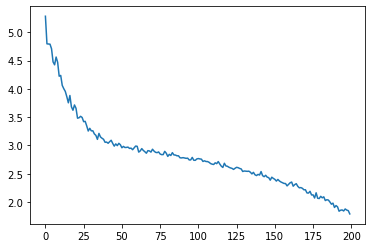

In [10]:
class Tanh_ (nn.Module) :
    def __init__ (self, c=1.0) : 
        super(Tanh_, self).__init__()
        self.c = c
        self.tanh = nn.Tanh()
        
    def forward (self, x) :
        return self.c * self.tanh(x)

class DiffusionModel (nn.Module) : 
    
    def __init__ (self, inDim=2, hiddenDim=64) : 
        super(DiffusionModel, self).__init__()
        self.inDim = inDim 
        self.hiddenDim = hiddenDim 
        self.shared = nn.Sequential(
            nn.Linear(inDim, hiddenDim),
            nn.ReLU(),
        )
        self.f_means = nn.ModuleList([
            nn.Linear(hiddenDim, inDim)
            for _ in range(STEPS - 2)
        ])
        # Predict diagonal covariance matrices of the reverse process (indexed by forward time-step) 
        self.f_covs = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hiddenDim, inDim),
                nn.Sigmoid()
            )
            for _ in range(STEPS - 2)
        ])
        
    def mean (self, x, t) : 
        f = self.shared(x)
        return self.f_means[t - 2](f)
    
    def cov (self, x, t) :
        f = self.shared(x)
        return self.f_covs[t - 2](f)
        
    def sample (self, nSamples) : 
        """ 
        Return the whole trajectory starting from the 
        isotropic gaussian
        """ 
        xs = []
        Pi = MultivariateNormal(torch.zeros(model.inDim), torch.eye(model.inDim))
        xs.append(Pi.sample((nSamples,)))
        for t in range(STEPS - 1, 1, -1) : 
            mu, c = self.mean(xs[-1], t), self.cov(xs[-1], t)
            P = MultivariateNormal(torch.flatten(mu), torch.diag(torch.flatten(c)))
            xs.append(P.sample((1,)).reshape(-1, model.inDim))
        return xs
        
    def objective (self, x0, xt, t) :
        """
        x0, xt have shape [batch_size, inDims]
        """
        ALPHA = 1 - BETA
        mu_0, cov_0 = product_of_gaussians(
            xt / math.sqrt(ALPHA),
            (BETA / ALPHA) * torch.ones_like(x0),
            math.sqrt(ALPHA) ** (t - 1) * x0,
            (1 - (ALPHA) ** (t - 1)) * torch.ones_like(x0),
        )
        mu_1 = self.mean(xt, t) 
        cov_1 = self.cov(xt, t)
        return kl_divergence(mu_0, cov_0, mu_1, cov_1)
        
    def forward (self, x) : 
        """
        xs shape is [STEPS, batch_size, inDims]
        """
        _, bs, _ = x.shape
        x0 = x[0, :, :] 
        loss = 0 
        for t in range(2, STEPS) : 
            xt = x[t, :, :]
            loss += self.objective(x0, xt, t)
        loss /= STEPS
        return loss
    
def sample (data, bs) : 
    N, _ = data.shape
    ids = random.sample(list(range(N)), bs)
    x = data[ids, :] 
    pts = [x]
    for i in range(STEPS) : 
        x = forward_step(x) 
        pts.append(x)
    pts = np.stack(pts)
    return torch.tensor(pts)

N_EPOCH = 200 # Number of epochs

model = DiffusionModel()
model.float()
opt = optim.SGD(model.parameters(), lr=9e-2)
losses = []
for i in range(N_EPOCH) : 
    x = sample(data, 40)
    x = x.float()
    loss = model.forward(x)
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.detach().item())
    
plt.plot(range(N_EPOCH), losses)

tensor([-0.1434, -0.2131])
tensor([1.0577, 1.0620])


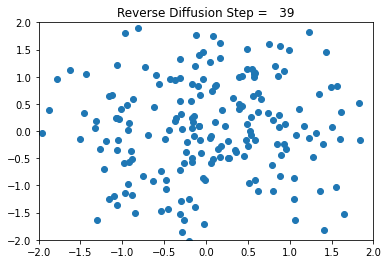

In [11]:
xs = model.sample(200)
fig, ax = plt.subplots()

ax.set_xlim((-2, 2))            
ax.set_ylim((-2, 2))
txt_title = ax.set_title('')
scat = ax.scatter([], [])

def drawframe (t):
    global pts
    scat.set_offsets(xs[t % len(xs)])
    txt_title.set_text('Reverse Diffusion Step = {0:4d}'.format(t))
    return (scat,)

anim = animation.FuncAnimation(fig, drawframe, frames=STEPS, interval=200, blit=True)
print(xs[-1].mean(0))
print(xs[-1].std(0))
HTML(anim.to_html5_video())

## References 

1. Deep Unsupervised Learning using Nonequilibrium Thermodynamics
2. Denoising Diffusion Probabilistic Models